# Chess data

Analysis of my own games from chess.com. Data obtained using their in-built download (into a single text file)

## Part 1: data extraction

In [1]:
import pandas as pd

In [2]:
lines = []

with open("chess_com_games_2021-06-21.pgn", "r") as f:
    lines = f.read()

Assume each record starts with `[Event` and use that as a separator

In [3]:
# first one will be an empty string, ignore that
raw_games = lines.split("[Event")[1:]
len(raw_games)

46

Create a function to take a raw game string, and extract the metadata into a dictionary.

First, it will split each game by new lines into their separate meta-tags.

In [4]:
def extract_game_info(game):

    # separate the list of metadata attributes from the list of moves
    metadata = [section for section in game.split("\n\n") if section != ""]

    assert(len(metadata) == 2)

    # save them into separate variables
    columns_string, moves_string = metadata

    # make the metadata columns into a list
    columns = columns_string.split("\n")

    # get rid of first meta-tag as it's the incomplete event name
    del columns[0]
    
    # keep track of metadata in a dictionary
    game_dict = {}

    # loop through the tags
    for column in columns:
        # identify where the first space is
        first_space = column.index(" ")

        # what's to the left of the first space is the column name
        # (exclude the first square bracket)
        column_name = column[1:first_space]

        # to the right is the column value (exclude the final square bracket)
        column_value = column[first_space+1:-1]

        # get rid of double quotes
        column_value = column_value.replace('"', '')

        # add a value to the dictionary
        game_dict[column_name] = column_value

    # add the entire list of moves to the dictionary
    game_dict["Moves"] = moves_string
    
    return game_dict

Test the function

In [5]:
game = raw_games[1]
extract_game_info(game)

{'Site': 'Chess.com',
 'Date': '2017.10.18',
 'Round': '-',
 'White': 'agrazi',
 'Black': 'abcdave',
 'Result': '0-1',
 'WhiteElo': '1206',
 'BlackElo': '1494',
 'TimeControl': '1/432000',
 'EndDate': '2017.12.03',
 'Termination': 'abcdave won by checkmate',
 'Moves': '1. e4 c5 2. d4 cxd4 3. Qxd4 Nc6 4. Qc5 e5 5. Qd5 Nf6 6. Qb5 Nxe4 7. Bd3 Nd6 8.\nQd5 Qf6 9. Nh3 Nb4 10. Qb3 Nxd3+ 11. Qxd3 e4 12. Qc3 Qg6 13. O-O Be7 14. Nf4 Qf6\n15. Nd5 Qxc3 16. bxc3 Rb8 17. Bf4 b6 18. Nc7+ Kd8 19. Nd5 g5 20. Be5 Bb7 21. Ne3\nf6 22. Bd4 Rc8 23. Nd2 Rf8 24. g4 Nb5 25. c4 Nxd4 26. Rae1 Bb4 27. Nb3 Bxe1 28.\nNxd4 Bd2 29. Nef5 Rxc4 30. Nb5 Rxc2 31. Nxa7 Rxa2 32. Nb5 Ba6 33. Nbd6 Bxf1 34.\nKxf1 Bf4 35. Nxe4 Bxh2 36. Ng7 b5 37. Nc3 Ra1+ 38. Kg2 b4 39. Nf5 bxc3 40. Kxh2\nc2 41. Ne3 c1=Q 42. Kg3 Ra3 43. Kg2 Rh8 44. Nf1 Ra1 45. Ng3 h5 46. gxh5 Rxh5 47.\nNxh5 Qh1+ 48. Kg3 Rg1# 0-1'}

Apply the function and create a DataFrame

In [6]:
game_dictionaries = [extract_game_info(game) for game in raw_games]

df = pd.DataFrame(game_dictionaries)
df.head()

,Site,Date,Round,White,Black,Result,WhiteElo,BlackElo,TimeControl,EndDate,Termination,Moves,Variant,SetUp,FEN
0,Chess.com,2017.10.18,-,abcdave,utopa,1-0,1400,800,1/604800,2017.10.26,abcdave won on time,1. e4 e5 2. Nf3 d6 3. Nc3 1-0,NaN,NaN,NaN
1,Chess.com,2017.10.18,-,agrazi,abcdave,0-1,1206,1494,1/432000,2017.12.03,abcdave won by checkmate,1. e4 c5 2. d4 cxd4 3. Qxd4 Nc6 4. Qc5 e5 5. Q...,NaN,NaN,NaN
2,Chess.com,2017.11.07,-,abcdave,hetverschil,0-1,1335,1384,1/432000,2017.12.17,hetverschil won by resignation,1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. O-O Nf6 5. d...,NaN,NaN,NaN
3,Chess.com,2017.12.04,-,abcdave,agrazi,1-0,1394,1191,1/172800,2017.12.27,abcdave won by resignation,1. e4 e5 2. f4 exf4 3. Nf3 d6 4. d4 Bd7 5. Bxf...,NaN,NaN,NaN
4,Chess.com,2017.12.28,-,agrazi,abcdave,0-1,1179,1431,1/172800,2018.01.08,abcdave won by resignation,1. e4 e5 2. d3 Nf6 3. Be3 c6 4. Nf3 d6 5. Be2 ...,NaN,NaN,NaN


## Part 2: Analysis

My research question is "how do I perform within different opening systems?"

### But first: data cleaning!

"Variants": NULLs are regular chess games, non-NULLs are different game modes (which we want to exclude)

In [8]:
df = df[df["Variant"].isnull()] # only keep NULLs!

Any draws?

In [9]:
df["Result"].value_counts()

0-1        22
1-0        21
1/2-1/2     1
Name: Result, dtype: int64

Create a "did I win?" column based on the result + the player names

In [12]:
# either white won and I was white, or black won and I was black
df["did_I_win"] = (
        ((df["Result"] == "1-0") & (df["White"] == "abcdave"))
        |
        ((df["Result"] == "0-1") & (df["Black"] == "abcdave"))
)

df["did_I_win"].value_counts(dropna=False)

True     27
False    17
Name: did_I_win, dtype: int64

Create a "which colour was I" column

In [25]:
import numpy as np

df["my_colour"] = np.where(df["White"] == "abcdave", "White", "Black")
df["my_colour"].value_counts(dropna=False)

Black    20
White    19
Name: my_colour, dtype: int64

Remove games that ended due to timeout

In [16]:
df.drop(df[df["Termination"].str.contains("on time")].index, inplace=True)

df["did_I_win"].value_counts(dropna=False)

True     22
False    17
Name: did_I_win, dtype: int64

### Analysis: openings

Extract the first moves as a proxy for the opening.

What I *really* want to know is the name of the opening system (e.g. Sicilian) but I don't currently have data for that, so we will use the first 2-4 moves as a proxy.

Let's start with the single first move.

In [24]:
df["first_move"] = df["Moves"].str.split(" ").str[1]

df["first_move"].value_counts()

e4    28
d4     9
c4     2
Name: first_move, dtype: int64

What I want to do is look at my win percentage as white and black for different opening moves

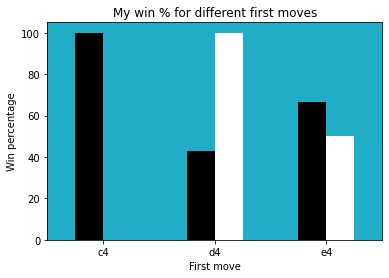

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

(
    (df.groupby(["first_move", "my_colour"]) # separate bars for black and white
     ["did_I_win"].mean() * 100) # multiply by 100 for convenience
    .unstack() # shape data so matplotlib is happy
    .plot.bar(ax=ax,
              color=["black", "white"] # add chess colours
             )
)

ax.set(title="My win % for different first moves",
       xlabel="First move",
       ylabel="Win percentage",
       facecolor="#20adc7")

ax.legend().remove()

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()